In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [7]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

### a) Constitutive promoter

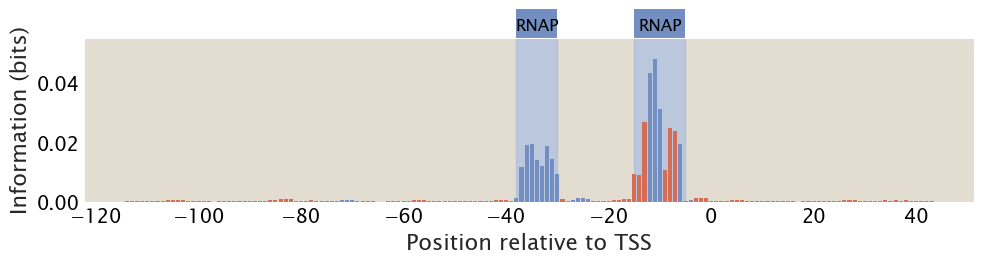

In [8]:
n_NS = len(genome)
ep_wt = -5
n_p = 4600

df = tregs.simulate.sim(promoter, tregs.simulate.constitutive_pbound, [rnap_site],
                        *[n_NS, n_p, rnap_emat], scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig3/constitutive.pdf')

### b) Simple repression

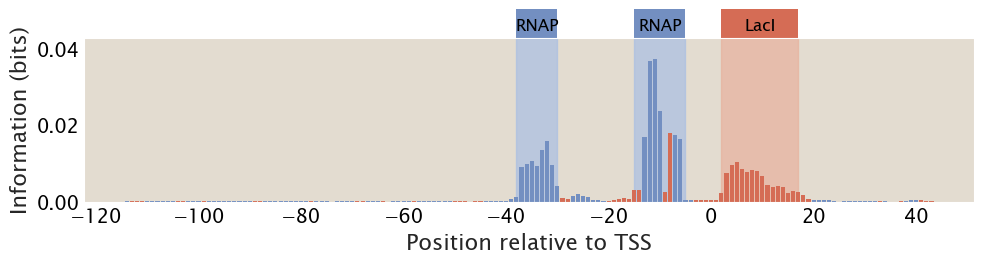

In [9]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig3/simrep.pdf')

### Simple activation

Here we use CRP binding at the lacZYA promoter as a case study for simple activation.

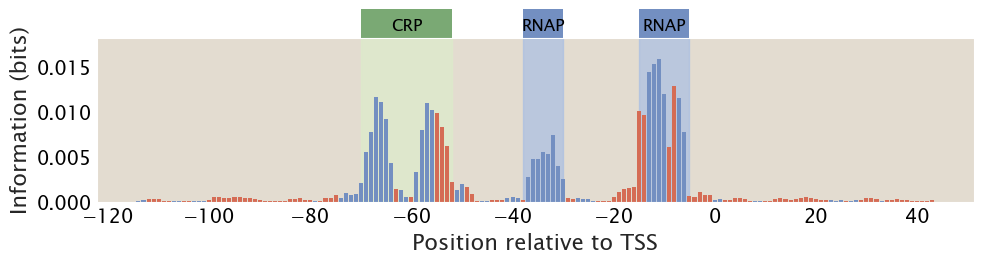

In [10]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
ea_wt = -13
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../plots/fig3/simact.pdf')

### Double repression

In [11]:
rep1_site = promoter[(115-50):(115-40)]
rep2_site = promoter[(115+15):(115+25)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

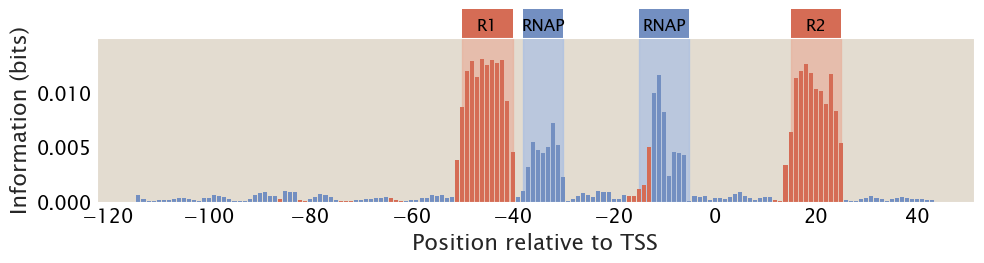

In [12]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r1, n_r2 = 4600, 15, 15

df = tregs.simulate.sim(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-50, -40, 'R', 'R1'), (15, 25, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../plots/fig3/double_rep.pdf')

### Double activation

In [13]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

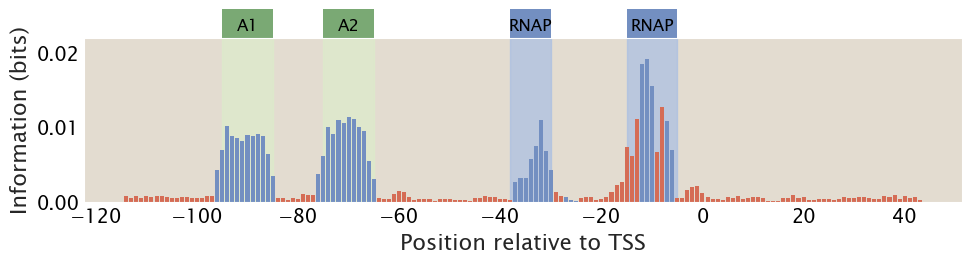

In [14]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, 'OR'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../plots/fig3/double_act.pdf')

### Repression-activation

In [15]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -13, -13
e_int = -10
n_p, n_r, n_a = 4600, 50, 50

df = tregs.simulate.sim(promoter, tregs.simulate.repact_pbound, [rnap_site, rep_site, crp_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, crp_emat, ep_wt, er_wt, ea_wt, e_int], scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]

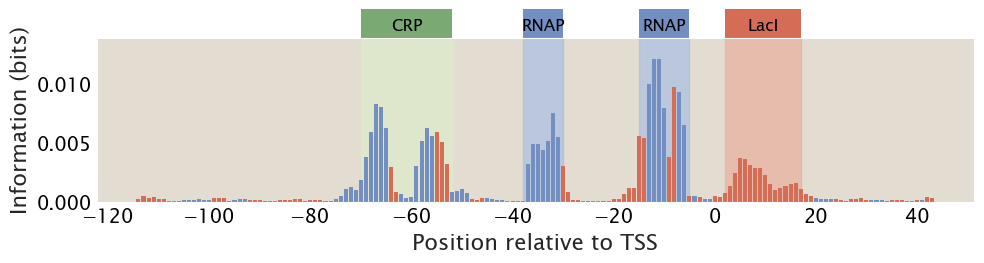

In [16]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../plots/fig3/repact.pdf')